In [1]:
from pyspark.sql import SQLContext, SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import when, col, count
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import pandas as pd

In [2]:
spark = SparkSession.Builder().appName('DDAM_Project_Mushrooms').getOrCreate()
sql_ctx = SQLContext(spark)
mushroom_df_cleaned = spark.read.options(inferSchema = True, delimiter = ',', header = True).csv('dataset/cleaned.csv')

your 131072x1 screen size is bogus. expect trouble
24/05/31 19:32:18 WARN Utils: Your hostname, LAPTOP-HBLRDRME resolves to a loopback address: 127.0.1.1; using 172.17.184.243 instead (on interface eth0)
24/05/31 19:32:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/31 19:32:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/home/fmitola2/.local/lib/python3.9/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
mushroom_df_cleaned.show()
mushroom_df_cleaned.count()

+-----+------------+---------+-----------+---------+--------------------+---------------+----------+-----------+----------+----------+--------+---------+-------+------+
|class|cap-diameter|cap-shape|cap-surface|cap-color|does-bruise-or-bleed|gill-attachment|gill-color|stem-height|stem-width|stem-color|has-ring|ring-type|habitat|season|
+-----+------------+---------+-----------+---------+--------------------+---------------+----------+-----------+----------+----------+--------+---------+-------+------+
|    e|       10.96|        f|          i|        l|                   f|              s|         b|       7.23|     1.915|         b|       f|        f|      l|     a|
|    e|        9.33|        f|          i|        l|                   f|              s|         b|       7.36|     1.894|         b|       f|        f|      d|     w|
|    e|        11.0|        f|          i|        l|                   f|              s|         b|       8.28|     1.988|         u|       f|        f|  

60014

In [4]:
cat_cols = [element[0] for element in mushroom_df_cleaned.dtypes if element[1] == 'string']
print('The categorical columns are')
print(cat_cols)

The categorical columns are
['class', 'cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-color', 'stem-color', 'has-ring', 'ring-type', 'habitat', 'season']


In [5]:
num_cols = [element[0] for element in mushroom_df_cleaned.dtypes if element[1] != 'string']
print('The numerical columns are')
print(num_cols)

The numerical columns are
['cap-diameter', 'stem-height', 'stem-width']


Feature Preprocessing for the classification

In [6]:
bool_cols = ['does-bruise-or-bleed', 'has-ring']

mushroom_df_cleaned = mushroom_df_cleaned.withColumn("class_indexed", when(mushroom_df_cleaned['class'].contains('e'), 0).otherwise(1))

for c in bool_cols:
    mushroom_df_cleaned = mushroom_df_cleaned.withColumn(f"{c}_indexed", when(mushroom_df_cleaned[c].contains('f'), 0).otherwise(1))

bool_cols.append('class')

remaining_cols = [item for item in cat_cols if item not in bool_cols]

for c in remaining_cols:
    indexer_fitted = StringIndexer(inputCol=c, outputCol=f"{c}_indexed").fit(mushroom_df_cleaned)
    mushroom_df_cleaned = indexer_fitted.transform(mushroom_df_cleaned)

mushroom_df_cleaned = mushroom_df_cleaned.drop(*cat_cols)

In [7]:
valid_cols = ['cap-diameter', 'stem-height', 'stem-width', 'does-bruise-or-bleed_indexed',
 'has-ring_indexed', 'cap-shape_indexed', 'cap-surface_indexed', 'cap-color_indexed',
 'gill-attachment_indexed', 'gill-color_indexed', 'stem-color_indexed',
 'ring-type_indexed', 'habitat_indexed', 'season_indexed']


assembler = VectorAssembler(inputCols=valid_cols, outputCol="input_features")

dataset = assembler.transform(mushroom_df_cleaned)

dataset = dataset.withColumnRenamed('class_indexed', 'isPoisonous')

classification_df = dataset.select("input_features", "isPoisonous")

classification_df.show(truncate=False)


24/05/31 19:32:40 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------------------------------------------------------------+-----------+
|input_features                                                   |isPoisonous|
+-----------------------------------------------------------------+-----------+
|[10.96,7.23,1.915,0.0,0.0,1.0,9.0,11.0,4.0,11.0,12.0,0.0,2.0,0.0]|0          |
|[9.33,7.36,1.894,0.0,0.0,1.0,9.0,11.0,4.0,11.0,12.0,0.0,0.0,2.0] |0          |
|[11.0,8.28,1.988,0.0,0.0,1.0,9.0,11.0,4.0,11.0,6.0,0.0,2.0,2.0]  |0          |
|[14.75,8.4,2.211,0.0,0.0,1.0,9.0,11.0,4.0,11.0,12.0,0.0,2.0,0.0] |0          |
|[11.15,6.98,1.786,0.0,0.0,1.0,9.0,11.0,4.0,11.0,6.0,0.0,0.0,2.0] |0          |
|[10.71,8.24,1.989,0.0,0.0,1.0,9.0,11.0,4.0,11.0,12.0,0.0,0.0,0.0]|0          |
|[10.07,8.63,2.229,0.0,0.0,1.0,9.0,11.0,4.0,11.0,12.0,0.0,0.0,0.0]|0          |
|[9.48,7.28,2.091,0.0,0.0,1.0,9.0,11.0,4.0,11.0,6.0,0.0,2.0,0.0]  |0          |
|[8.61,8.41,2.004,0.0,0.0,1.0,9.0,11.0,4.0,11.0,12.0,0.0,0.0,2.0] |0          |
|[9.31,8.09,1.804,0.0,0.0,1.0,9.0,11.0,4

In [8]:
def value_counts(df):
   grouped_df = df.select("isPoisonous").groupBy("isPoisonous").agg(count("isPoisonous").alias("total_value"))
   proportions = grouped_df.withColumn("proportions", col("total_value") / df.count()).select("isPoisonous","proportions")
   return proportions
 

In [9]:
#Initial class distributions
value_counts(classification_df).show()

+-----------+------------------+
|isPoisonous|       proportions|
+-----------+------------------+
|          1|0.5546039257506582|
|          0|0.4453960742493418|
+-----------+------------------+



In [10]:
(dev_df, test_df) = classification_df.randomSplit([0.7, 0.3],seed=0)

In [11]:
#Verify the class distributions after the split
value_counts(dev_df).show()
value_counts(test_df).show()

+-----------+-------------------+
|isPoisonous|        proportions|
+-----------+-------------------+
|          1| 0.5569981452418319|
|          0|0.44300185475816806|
+-----------+-------------------+



+-----------+------------------+
|isPoisonous|       proportions|
+-----------+------------------+
|          1|0.5489977728285078|
|          0|0.4510022271714922|
+-----------+------------------+



In [12]:
nb = NaiveBayes(labelCol="isPoisonous", featuresCol="input_features")

# performing grid search
paramGrid = ParamGridBuilder() \
    .addGrid(nb.modelType, ["multinomial", "gaussian"])\
    .build()
   

evaluator = MulticlassClassificationEvaluator(labelCol="isPoisonous", predictionCol="prediction", metricName='accuracy')

crossval = CrossValidator(estimator=nb,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5,
                          parallelism=5,
                          collectSubModels = True,
                          seed = 42)

cv_model = crossval.fit(dev_df)

24/05/31 19:32:53 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [13]:
results = []

# Extract average metrics for each parameter combination to make a ranking
for idx, params in enumerate(cv_model.getEstimatorParamMaps()):
    param_dict = {param.name: value for param, value in params.items()}
    avg_metric = cv_model.avgMetrics[idx]
    results.append({**param_dict, "avg_accuracy": avg_metric})

# Making a ranking of tested models, ordered by avg_accuracy
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('avg_accuracy', ascending=False)
print(results_df)

     modelType  avg_accuracy
0  multinomial      0.618732
1     gaussian      0.603020


In [14]:
best_model = cv_model.bestModel

param_dict = best_model.extractParamMap()
# Convert the keys to strings for easier access
sane_dict = {}
for k, v in param_dict.items():
    sane_dict[k.name] = v

# best model hyper-parameters
print(f"best config: modelType: {sane_dict['modelType']}")


predictions = best_model.transform(test_df)
accuracy = evaluator.evaluate(predictions)

evaluator.setMetricName("f1")
f1 = evaluator.evaluate(predictions)

evaluator.setMetricName("weightedPrecision")
precision = evaluator.evaluate(predictions)

evaluator.setMetricName("weightedRecall")
recall = evaluator.evaluate(predictions)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"0/1 Error: {1.0 - accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

best config: modelType: multinomial


Test Accuracy: 0.6133
0/1 Error: 0.3867
F1 Score: 0.6138
Precision: 0.6146
Recall: 0.6133


/home/fmitola2/.local/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


[[4770. 3330.]
 [3616. 6244.]]


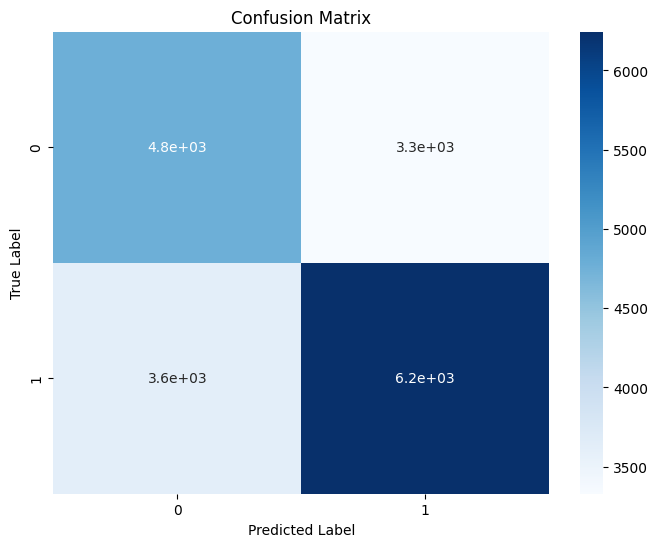

In [15]:
preds_and_labels = predictions.select("prediction", "isPoisonous")
preds_and_labels_rdd = preds_and_labels.rdd.map((lambda x: (float(x['prediction']), float(x['isPoisonous']))))

metrics = MulticlassMetrics(preds_and_labels_rdd)
confusion_matrix = metrics.confusionMatrix().toArray()
print(confusion_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, cmap="Blues")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()